<a href="https://colab.research.google.com/github/ccikss519/cjl/blob/main/SegNet_CamVid11_Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import tensorflow 
'''
导入My Drive 中的文件
'''
import sys
from google.colab import drive
drive.mount('/content/drive')
#sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/Bayesian_SegNet')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import keras
from keras import backend
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from src.datasets.camvid import camvid
from src import evaluate
from src import plot
from src import predict
from src import segnet
from src.callbacks import PlotMetrics
from src.utils import history_to_results

from uncertainty_propagator.uncertainty_propagator import UncertaintyPropagator

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# %tensorflow_version 2.x
# import sys
# sys.path[0]="/tensorflow-2.1.0/python3.6"
# import tensorflow 
# tf.__version__


In [7]:
import tensorflow as tf

print(tf.__version__)

print(keras.__version__)

print(keras.backend.get_session)

from keras import backend



2.6.0
2.6.0
<function get_session at 0x7f43d2341320>


In [8]:
import pickle
import numpy as np
# dat = pickle.load(open('sigma.pkl', 'rb'))
# print(dat)

In [9]:
weights_file = 'models/SegNet-CamVid11-Bayesian.h5'

In [10]:
# the batch size for training the network
batch_size = 1
# the size to crop images to
crop_size = (352, 480)

In [11]:
# Preprocess images once
camvid11 = camvid.CamVid(
    mapping=camvid.CamVid.load_mapping(), 
    target_size=(360, 480), 
    crop_size=crop_size, 
    batch_size=batch_size,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 376 images belonging to 1 classes.
Found 367 images belonging to 1 classes.


Example images

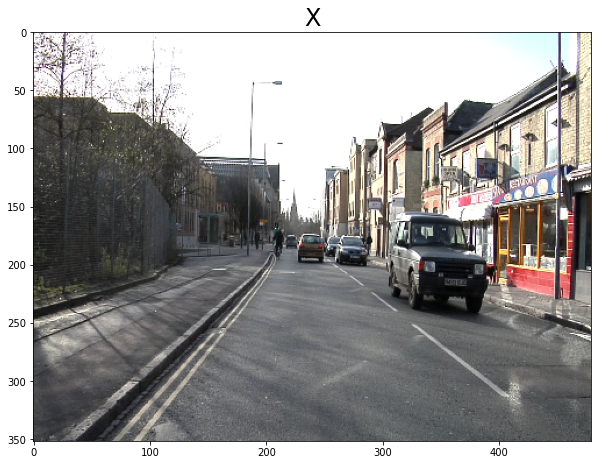

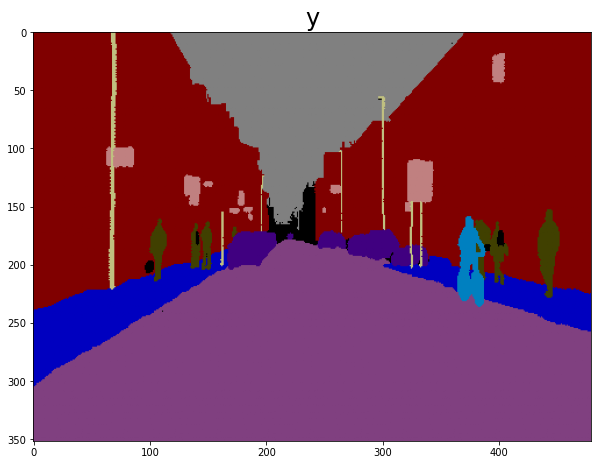

In [12]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = plot.plot_list([X[0], y[0]], ['X', 'y'])

# Training

If we hold out classes during training we mask the loss of the corresponding classes (here: pedestrians and cyclist). We use two types of architectures: EncDecCenter -> dropout after the central 4 encoder and decoder blocks; Class -> dropout only prior to the final layer

In [13]:
hold_out_pedestrian = False
hold_out_byciclist = False

class_weights = camvid11.class_weights
if hold_out_pedestrian:
    class_weights[5] = 0
if hold_out_byciclist: 
    class_weights[0] = 0

drop_rate = 0.5

In [14]:
# build the model for the image shape and number of labels
model = segnet.segnet((*crop_size, 3), camvid11.n, 
    class_weights=camvid11.class_weights,
    dropout_rate=drop_rate,
    bn_train=False
)
model.summary()

OperatorNotAllowedInGraphError: ignored

In [ ]:
# create the callbacks for the training procedure
callbacks = [
    EarlyStopping(monitor='loss', patience=50),
    LearningRateScheduler(lambda _, lr: 0.95 * lr),
    ModelCheckpoint(weights_file, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

In [ ]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=1,
)

In [ ]:
history_to_results(history)

# Test Metrics

In [ ]:
model.load_weights(weights_file)

Initialize the variance propagation network.

In [ ]:
# Adjust keras model for variance propagation
unc_prop = UncertaintyPropagator(model, mc_samples=100)
_ = unc_prop.build_model(exact=True)

In [ ]:
use_mc = False

# define whether to use mc predictions or our approximation
unc_prop.set_mc_mode(use_mc)

# compute metrics, callibration data, holdout uncertainty (if class hold out) and uncertainty per class
metrics, callibration_data, hold_out_uncertainty, unc_per_class = evaluate.evaluate(unc_prop, generators['test'], 233,
    mask=camvid11.class_mask, 
    code_map=camvid11.discrete_to_label_map
)

metrics_file_name = weights_file + '.csv' if use_mc else weights_file + '_our.csv'
metrics.to_csv(metrics_file_name)
metrics

The following creates a callibration plot. Thus uncertainty against the misclassification rate.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(callibration_data[0], callibration_data[1])
plt.show()used in the 

# Qualitative Results

### Train Results

In [ ]:
X, y, res = predict.predict_epistemic_all(unc_prop, generators['train'], camvid11)
_ = plot.plot_list([X[0], y[0], res['mc'][0][0], res['approx'][0][0], res['mc'][1][0], res['approx'][1][0]], 
              ['X', 'y_true', 'y_pred_mc', 'y_pred_ours', 'uncertainty_mc', 'uncertainty_our'])

### Validation Results

In [ ]:
X, y, res = predict.predict_epistemic_all(unc_prop, generators['val'], camvid11)
_ = plot.plot_list([X[0], y[0], res['mc'][0][0], res['approx'][0][0], res['mc'][1][0], res['approx'][1][0]], 
              ['X', 'y_true', 'y_pred_mc', 'y_pred_ours', 'uncertainty_mc', 'uncertainty_our'])

### Test Results

In [ ]:
X, y, res = predict.predict_epistemic_all(unc_prop, generators['test'], camvid11)
_ = plot.plot_list([X[0], y[0], res['mc'][0][0], res['approx'][0][0], res['mc'][1][0], res['approx'][1][0]], 
              ['X', 'y_true', 'y_pred_mc', 'y_pred_ours', 'uncertainty_mc', 'uncertainty_our'])